# Survival Analysis: Democracy and dictatorship 
[Alonso Silva](http://www.dim.uchile.cl/~alsilva/) [(@alonsosilva)](https://twitter.com/alonsosilva) | 2019/09/09

The objective of this notebook is to estimate the probability of survival of a government since it took office until it was disolved.

We will perform this survival analysis with [lifelines](https://lifelines.readthedocs.io/en/latest/)

In [1]:
# install lifelines
!pip install lifelines

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [0]:
# download dataset
from lifelines.datasets import load_dd

df = load_dd()

* Classification of political regimes as democracy and dictatorship. 

* Classification of democracies as 
  + parliamentary, 
  + semi-presidential (mixed), and 
  + presidential. 
  
* Classification of dictatorships as 
  + military, 
  + civilian, and 
  + royal. 
  
Coverage: 202 countries, from 1946 or year of independence to 2008.

**References**

José Antonio Cheibub, Jennifer Gandhi, and James Raymond Vreeland. “Democracy and Dictatorship Revisited.” Public Choice, vol. 143, no. 2-1, pp. 67-101, 2010.

In [4]:
df.tail(10)

,ctryname,cowcode2,politycode,un_region_name,un_continent_name,ehead,leaderspellreg,democracy,regime,start_year,duration,observed
1798,Yugoslavia,345,345.0,Southern Europe,Europe,Stipe Suvar,Stipe Suvar.Yugoslavia.1988.1988.Civilian Dict,Non-democracy,Civilian Dict,1988,1,1
1799,Yugoslavia,345,345.0,Southern Europe,Europe,Milan Pancevski,Milan Pancevski.Yugoslavia.1989.1989.Civilian ...,Non-democracy,Civilian Dict,1989,1,1
1800,Yugoslavia,345,345.0,Southern Europe,Europe,Borisav Jovic,Borisav Jovic.Yugoslavia.1990.1990.Civilian Dict,Non-democracy,Civilian Dict,1990,1,0
1801,Zambia,551,551.0,Eastern Africa,Africa,Kenneth Kaunda,Kenneth Kaunda.Zambia.1964.1990.Civilian Dict,Non-democracy,Civilian Dict,1964,27,1
1802,Zambia,551,551.0,Eastern Africa,Africa,Frederick Chiluba,Frederick Chiluba.Zambia.1991.2001.Civilian Dict,Non-democracy,Civilian Dict,1991,11,1
1803,Zambia,551,551.0,Eastern Africa,Africa,Levy Patrick Mwanawasa,Levy Patrick Mwanawasa.Zambia.2002.2007.Civili...,Non-democracy,Civilian Dict,2002,6,1
1804,Zambia,551,551.0,Eastern Africa,Africa,Rupiah Bwezani Banda,Rupiah Bwezani Banda.Zambia.2008.2008.Civilian...,Non-democracy,Civilian Dict,2008,1,0
1805,Zimbabwe,552,552.0,Eastern Africa,Africa,Ian Smith,Ian Smith.Zimbabwe.1965.1978.Civilian Dict,Non-democracy,Civilian Dict,1965,14,1
1806,Zimbabwe,552,552.0,Eastern Africa,Africa,Abel Muzorewa,Abel Muzorewa.Zimbabwe.1979.1979.Civilian Dict,Non-democracy,Civilian Dict,1979,1,1
1807,Zimbabwe,552,552.0,Eastern Africa,Africa,Robert Mugabe,Robert Mugabe.Zimbabwe.1980.2008.Civilian Dict,Non-democracy,Civilian Dict,1980,29,0


In [0]:
T = df['duration']
C = df['observed']

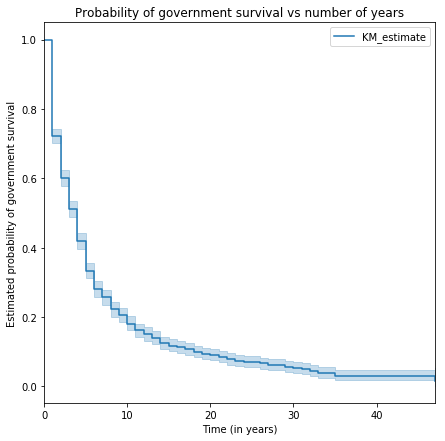

In [6]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(T,C)
plt.figure(figsize=(7,7))
ax = plt.subplot(111)
kmf.plot(ax=ax)
plt.title('Probability of government survival vs number of years')
plt.xlabel('Time (in years)')
plt.ylabel('Estimated probability of government survival')
plt.show()

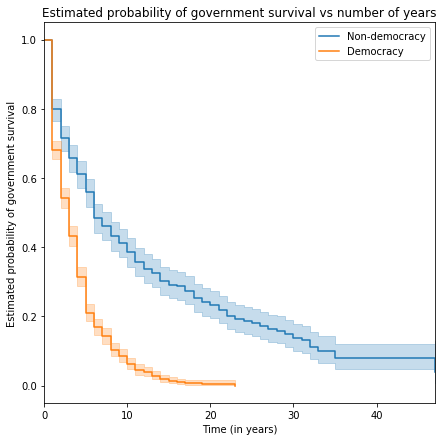

In [7]:
plt.figure(figsize=(7,7))
ax = plt.subplot(111)

for r in df['democracy'].unique():
  ix = df['democracy'] == r
  kmf.fit(T.loc[ix], C.loc[ix], label=r)
  kmf.plot(ax=ax)
plt.title('Estimated probability of government survival vs number of years')
plt.xlabel('Time (in years)')
plt.ylabel('Estimated probability of government survival')
plt.show()

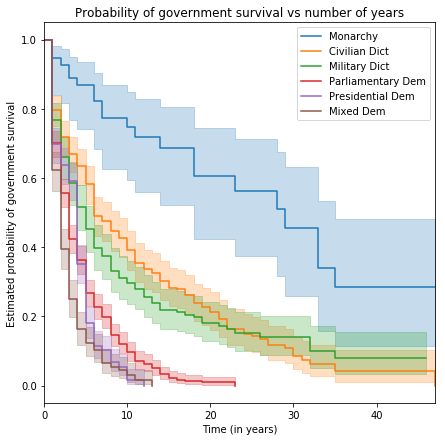

In [8]:
plt.figure(figsize=(7,7))
ax = plt.subplot(111)

for r in df['regime'].unique():
  ix = df['regime'] == r
  kmf.fit(T.loc[ix], C.loc[ix], label=r)
  kmf.plot(ax=ax)
plt.title('Probability of government survival vs number of years')
plt.xlabel('Time (in years)')
plt.ylabel('Estimated probability of government survival')
plt.show()

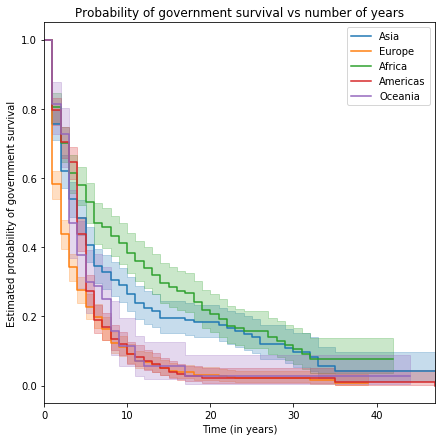

In [9]:
plt.figure(figsize=(7,7))
ax = plt.subplot(111)

for r in df['un_continent_name'].unique():
  ix = df['un_continent_name'] == r
  kmf.fit(T.loc[ix], C.loc[ix], label=r)
  kmf.plot(ax=ax)
plt.title('Probability of government survival vs number of years')
plt.xlabel('Time (in years)')
plt.ylabel('Estimated probability of government survival')
plt.show()

In [10]:
df['un_region_name'].unique()

array(['Southern Asia', 'Southern Europe', 'Northern Africa',
       'Middle Africa', 'Caribbean', 'South America', 'Western Asia',
       'Australia and New Zealand', 'Western Europe', 'Eastern Europe',
       'Central America', 'Western Africa', 'Southern Africa',
       'South-Eastern Asia', 'Eastern Africa', 'Northern America',
       'Eastern Asia', 'Northern Europe', 'Melanesia', 'Central Asia',
       'Micronesia', 'Polynesia'], dtype=object)

In [0]:
ix_na = df['un_region_name'] == 'Northern America'
ix_sa = df['un_region_name'] == 'South America'
ix_we = df['un_region_name'] == 'Western Europe'
ix_ee = df['un_region_name'] == 'Eastern Europe'

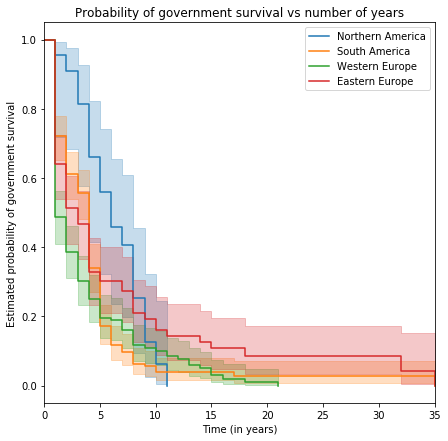

In [12]:
kmf_na = KaplanMeierFitter()
kmf_sa = KaplanMeierFitter()
kmf_we = KaplanMeierFitter()
kmf_ee = KaplanMeierFitter()

kmf_na.fit(T.loc[ix_na], C.loc[ix_na], label='Northern America')
kmf_sa.fit(T.loc[ix_sa], C.loc[ix_sa], label='South America')
kmf_we.fit(T.loc[ix_we], C.loc[ix_we], label='Western Europe')
kmf_ee.fit(T.loc[ix_ee], C.loc[ix_ee], label='Eastern Europe')

plt.figure(figsize=(7,7))
ax = plt.subplot(111)
kmf_na.plot(ax=ax)
kmf_sa.plot(ax=ax)
kmf_we.plot(ax=ax)
kmf_ee.plot(ax=ax)
plt.title('Probability of government survival vs number of years')
plt.xlabel('Time (in years)')
plt.ylabel('Estimated probability of government survival')
plt.show()

In [13]:
df.query('ctryname == "Chile"')

,ctryname,cowcode2,politycode,un_region_name,un_continent_name,ehead,leaderspellreg,democracy,regime,start_year,duration,observed
290,Chile,155,155.0,South America,Americas,Gabriel Gonzalez Videla,Gabriel Gonzalez Videla.Chile.1946.1951.Presid...,Democracy,Presidential Dem,1946,6,1
291,Chile,155,155.0,South America,Americas,Carlos Ibanez del Campo,Carlos Ibanez del Campo.Chile.1952.1957.Presid...,Democracy,Presidential Dem,1952,6,1
292,Chile,155,155.0,South America,Americas,Jorge Alessandri Rodriguez,Jorge Alessandri Rodriguez.Chile.1958.1963.Pre...,Democracy,Presidential Dem,1958,6,1
293,Chile,155,155.0,South America,Americas,Eduardo Frei Montalva,Eduardo Frei Montalva.Chile.1964.1969.Presiden...,Democracy,Presidential Dem,1964,6,1
294,Chile,155,155.0,South America,Americas,Salvador Allende Gossens,Salvador Allende Gossens.Chile.1970.1972.Presi...,Democracy,Presidential Dem,1970,3,0
295,Chile,155,155.0,South America,Americas,Augusto Pinochet Ugarte,Augusto Pinochet Ugarte.Chile.1973.1989.Milita...,Non-democracy,Military Dict,1973,17,1
296,Chile,155,155.0,South America,Americas,Patricio Aylwin Azacar,Patricio Aylwin Azacar.Chile.1990.1993.Preside...,Democracy,Presidential Dem,1990,4,1
297,Chile,155,155.0,South America,Americas,Eduardo Frei Ruiz-Tagle,Eduardo Frei Ruiz-Tagle.Chile.1994.1999.Presid...,Democracy,Presidential Dem,1994,6,1
298,Chile,155,155.0,South America,Americas,Ricardo Froilan Lagos Escobar,Ricardo Froilan Lagos Escobar.Chile.2000.2005....,Democracy,Presidential Dem,2000,6,1
299,Chile,155,155.0,South America,Americas,Verï¿½nica Michelle Bachelet Jeria,Verï¿½nica Michelle Bachelet Jeria.Chile.2006....,Democracy,Presidential Dem,2006,3,0


In [0]:
ix_chile = df['ctryname'] == 'Chile'

In [0]:
list_sa_nochile = [ix_sa[i] and not ix_chile[i] for i in range(len(ix_sa))]
serie_sa_nochile = pd.Series(list_sa_nochile)

In [0]:
kmf_chile = KaplanMeierFitter()
kmf_sa_nochile = KaplanMeierFitter()

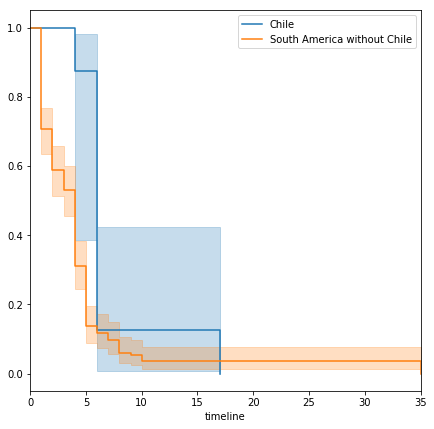

In [17]:
kmf_chile.fit(T.loc[ix_chile], C.loc[ix_chile], label='Chile')
kmf_sa_nochile.fit(T.loc[serie_sa_nochile], C.loc[serie_sa_nochile], label='South America without Chile')

plt.figure(figsize=(7,7))
ax = plt.subplot(111)
kmf_chile.plot(ax=ax)
kmf_sa_nochile.plot(ax=ax)
plt.show()

**Sources:**

[Lifelines: Survival Analysis in Python](https://www.youtube.com/watch?v=XQfxndJH4UA) 